In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils
from whittaker_smooth import whittaker_smooth
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

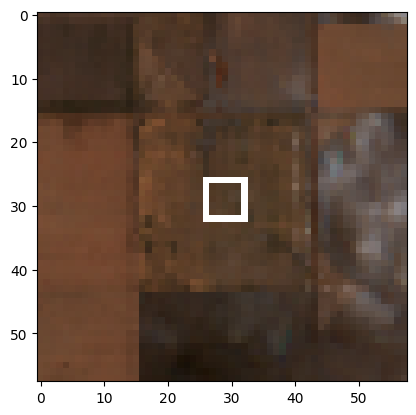

In [68]:
IMGS_PATH = '/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba1-2/'
bands =  ['B4','B3','B2','B8']

# Dict of the images.
images = utils.load_landsat_image(IMGS_PATH, bands)

# Get the days after plant and the dates.
days, dates, hours = utils.images_time_info(images.keys())

# Calculate the NDVI series over the crop.
ndvi_series = utils.generate_ndvi_time_series(images)

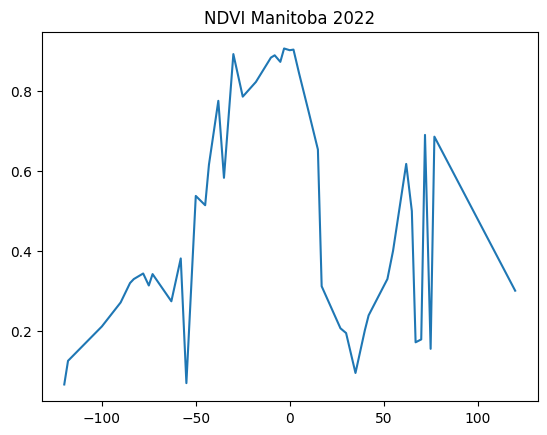

In [69]:
plt.plot(days, ndvi_series)
plt.title('NDVI Manitoba 2022')
plt.show()

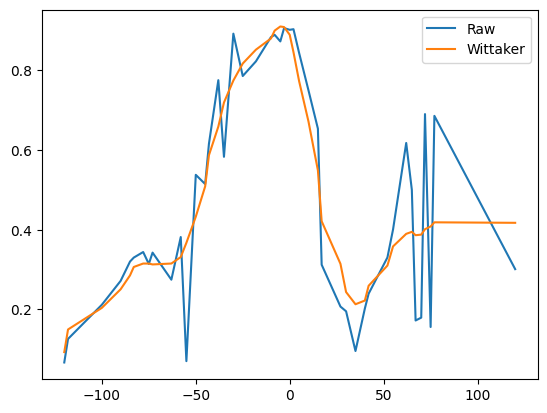

In [70]:
# Perform a Whittaker Smooth.
y_ = whittaker_smooth(np.array(ndvi_series), lmbd=10)
plt.plot(days, ndvi_series, label="Raw")
plt.plot(days, y_, label='Wittaker')
plt.legend()
plt.show()

In [71]:
df = pd.DataFrame(columns=["Dates", "Values"])
df["Dates"] = pd.to_datetime(dates)
df["Values"] = y_
df = df.resample('1D', on="Dates").agg("first").ffill() ## Quitar para eliminar resampling
df

,Values
Dates,
2020-04-03,0.092912
2020-04-04,0.092912
2020-04-05,0.149741
2020-04-06,0.149741
2020-04-07,0.149741
...,...
2020-11-25,0.418661
2020-11-26,0.418661
2020-11-27,0.418661


<AxesSubplot: xlabel='Dates'>

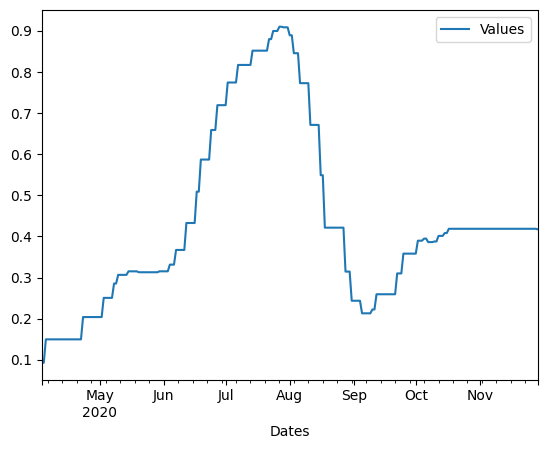

In [72]:
df.plot()

## Train/Test

In [73]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(np.asarray([testX]))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	error2 = mean_squared_error(test[:, -1], predictions)
	return error, error2, test[:, -1], predictions

In [74]:
# load the dataset
values = list(df["Values"])
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, mse, y, yhat = walk_forward_validation(data, 100)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

>expected=0.4, predicted=0.5
>expected=0.4, predicted=0.4
>expected=0.4, predicted=0.4
>expected=0.4, predicted=0.4
>expected=0.4, predicted=0.4
>expected=0.4, predicted=0.4
>expected=0.3, predicted=0.4
>expected=0.3, predicted=0.4
>expected=0.3, predicted=0.3
>expected=0.2, predicted=0.3
>expected=0.2, predicted=0.2
>expected=0.2, predicted=0.2
>expected=0.2, predicted=0.2
>expected=0.2, predicted=0.2
>expected=0.2, predicted=0.2
>expected=0.2, predicted=0.2
>expected=0.2, predicted=0.2
>expected=0.2, predicted=0.2
>expected=0.2, predicted=0.2
>expected=0.2, predicted=0.2
>expected=0.2, predicted=0.2
>expected=0.3, predicted=0.2
>expected=0.3, predicted=0.3
>expected=0.3, predicted=0.3
>expected=0.3, predicted=0.3
>expected=0.3, predicted=0.3
>expected=0.3, predicted=0.3


KeyboardInterrupt: 

In [ ]:
y_

array([0.09291245, 0.14974099, 0.20397145, 0.25063429, 0.28553969,
       0.30660595, 0.31522026, 0.31512775, 0.31296234, 0.31526033,
       0.33152394, 0.36719858, 0.4327465 , 0.50893841, 0.587054  ,
       0.65893945, 0.71929465, 0.77446309, 0.81716465, 0.85187919,
       0.87994814, 0.89977816, 0.91011641, 0.90863832, 0.88927232,
       0.84569168, 0.77281762, 0.67133204, 0.54899468, 0.42138592,
       0.31455674, 0.24364596, 0.21305977, 0.22237652, 0.25943576,
       0.31009493, 0.35822522, 0.38972798, 0.39476177, 0.38628879,
       0.38779808, 0.40137827, 0.40828534, 0.41866075, 0.41741218])

## Forecast

In [ ]:
# load the dataset
values = list(df["Values"])
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=90)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

predictions = []

for i in range(300):
# construct an input for a new preduction
    row = values[-90:]
# make a one-step prediction
    yhat = model.predict(np.asarray([row]))
    values.append(yhat[0])
    predictions.append(yhat[0])
    #print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

In [ ]:
list(df["Values"])

[0.09291244845967689,
 0.09291244845967689,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.149740985084547,
 0.20397145053990015,
 0.20397145053990015,
 0.20397145053990015,
 0.20397145053990015,
 0.20397145053990015,
 0.20397145053990015,
 0.20397145053990015,
 0.20397145053990015,
 0.20397145053990015,
 0.20397145053990015,
 0.25063429435224005,
 0.25063429435224005,
 0.25063429435224005,
 0.25063429435224005,
 0.25063429435224005,
 0.28553969405765245,
 0.28553969405765245,
 0.3066059454379892,
 0.3066059454379892,
 0.3066059454379892,
 0.3066059454379892,
 0.3066059454379892,
 0.31522025837953155,
 0.31522025837953155,
 0.31522025837953155,
 0.31512775085067135,
 0.31512775085067135,
 0.3129

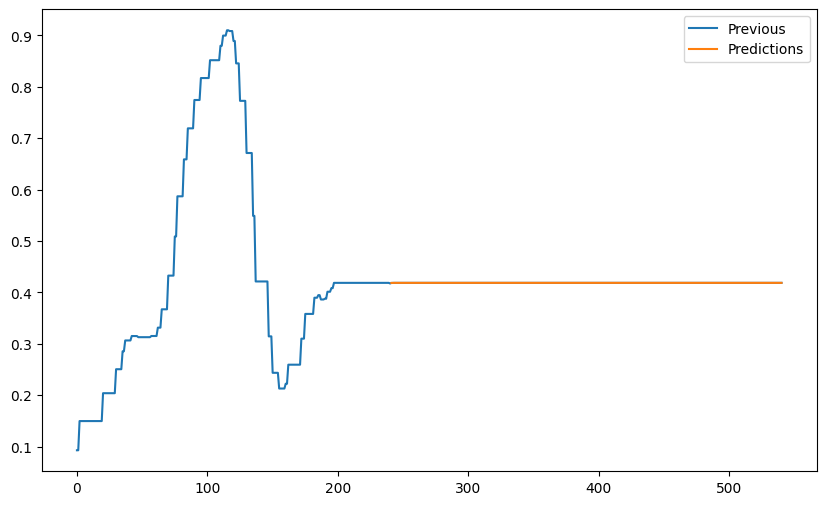

In [ ]:
plt.figure(figsize=(10,6))
plt.plot([i for i in range(len(values))], values, label="Previous")
plt.plot([i for i in range(len(df["Values"]), len(df["Values"])+len(predictions))], predictions, label="Predictions")
plt.legend()
plt.show()

# Interpolation

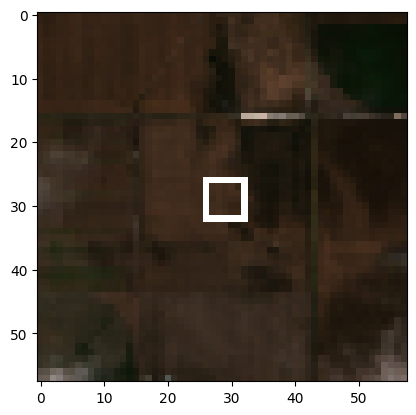

In [ ]:
IMGS_PATH = '/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba1-1/'
bands =  ['B4','B3','B2','B8']

# Dict of the images.
images = utils.load_landsat_image(IMGS_PATH, bands)

# Get the days after plant and the dates.
days, dates, hours = utils.images_time_info(images.keys())

# Calculate the NDVI series over the crop.
ndvi_series = utils.generate_ndvi_time_series(images)

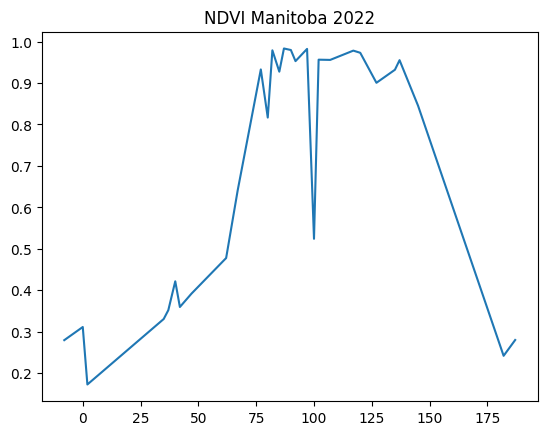

In [ ]:
plt.plot(days, ndvi_series)
plt.title('NDVI Manitoba 2022')
plt.show()

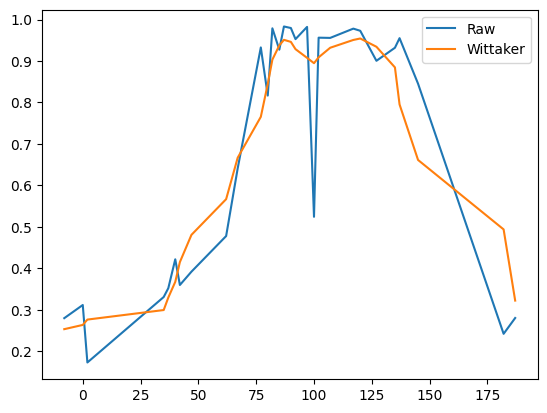

In [ ]:
# Perform a Whittaker Smooth.
smoothed = whittaker_smooth(np.array(ndvi_series), lmbd=10)
plt.plot(days, ndvi_series, label="Raw")
plt.plot(days, smoothed, label='Wittaker')
plt.legend()
plt.show()

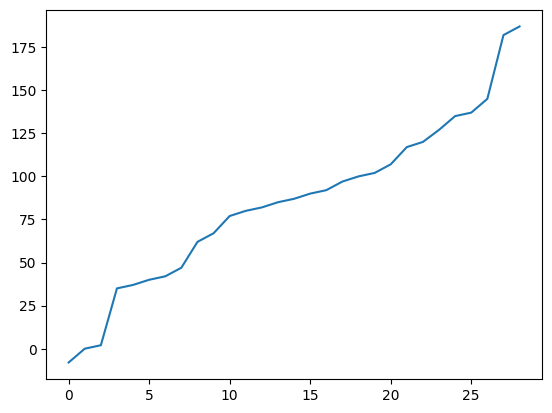

In [ ]:
plt.plot(days)

In [ ]:
x_new, y_new = utils.interpolate_curve(days, smoothed)

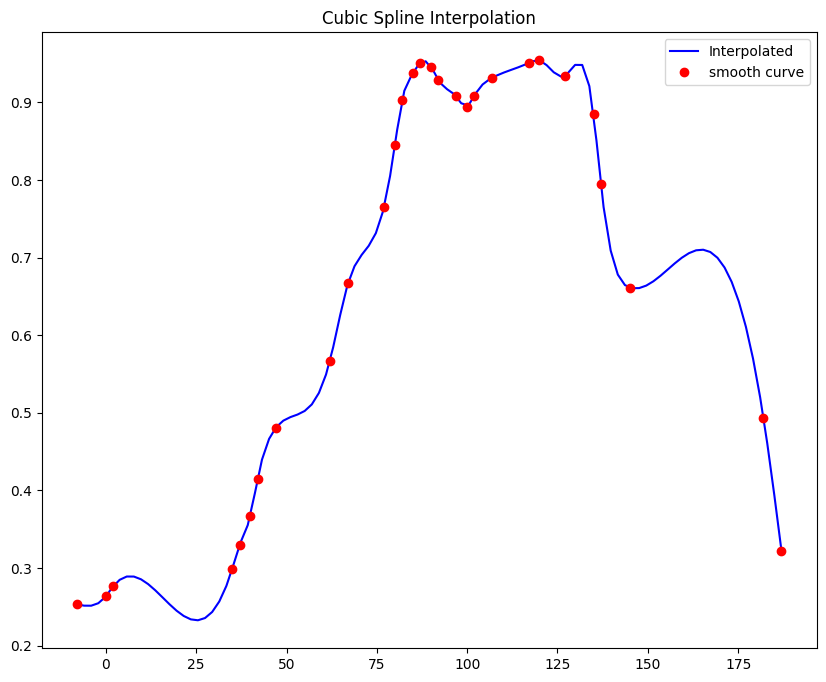

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(x_new, y_new, 'b', label='Interpolated')
plt.plot(days, smoothed, 'ro', label='smooth curve')
plt.title('Cubic Spline Interpolation')
plt.legend()
plt.show()

In [ ]:
y_new

array([0.25313787, 0.25145761, 0.25140373, 0.25460263, 0.26268067,
       0.27534024, 0.28475113, 0.28901147, 0.28895812, 0.285429  ,
       0.27926197, 0.27129492, 0.26236574, 0.25331231, 0.24497253,
       0.23818426, 0.23378541, 0.23261384, 0.23550746, 0.24330414,
       0.25684177, 0.27695824, 0.30446972, 0.33315964, 0.35523331,
       0.39624585, 0.43965448, 0.46643022, 0.48154012, 0.48990782,
       0.49447289, 0.49778141, 0.50237948, 0.51081317, 0.52562859,
       0.5493718 , 0.58435639, 0.62644224, 0.66435416, 0.68892492,
       0.70347802, 0.71526495, 0.73153862, 0.75955195, 0.80515359,
       0.86495423, 0.91500312, 0.93478427, 0.94872232, 0.95305931,
       0.94219979, 0.92548231, 0.91713251, 0.91069287, 0.89895644,
       0.89596897, 0.91132113, 0.92316092, 0.93007824, 0.93475581,
       0.93857223, 0.94194213, 0.94525751, 0.94891038, 0.9531005 ,
       0.95431278, 0.94806148, 0.93886649, 0.93342648, 0.93805568,
       0.94839913, 0.94830611, 0.92101547, 0.85089356, 0.76521

In [75]:
data = pd.read_csv("smoothed_data_kansas.csv")
y_new = data["y_22"]
y_new

0     0.278639
1     0.284120
2     0.287038
3     0.288571
4     0.290589
        ...   
95    0.261397
96    0.251886
97    0.242110
98    0.235696
99    0.225722
Name: y_22, Length: 100, dtype: float64

>expected=0.3, predicted=0.3
>expected=0.4, predicted=0.3
>expected=0.4, predicted=0.4
>expected=0.4, predicted=0.4
>expected=0.4, predicted=0.4
>expected=0.5, predicted=0.4
>expected=0.5, predicted=0.5
>expected=0.6, predicted=0.5
>expected=0.6, predicted=0.6
>expected=0.6, predicted=0.6
>expected=0.7, predicted=0.6
>expected=0.7, predicted=0.7
>expected=0.7, predicted=0.7
>expected=0.7, predicted=0.7
>expected=0.8, predicted=0.7
>expected=0.8, predicted=0.8
>expected=0.8, predicted=0.8
>expected=0.9, predicted=0.8
>expected=0.9, predicted=0.9
>expected=0.9, predicted=0.9
>expected=0.9, predicted=0.9
>expected=0.9, predicted=0.9
>expected=0.9, predicted=0.9
>expected=0.8, predicted=0.9
>expected=0.8, predicted=0.8
>expected=0.8, predicted=0.8
>expected=0.8, predicted=0.8
>expected=0.8, predicted=0.8
>expected=0.8, predicted=0.8
>expected=0.8, predicted=0.8
>expected=0.9, predicted=0.8
>expected=0.9, predicted=0.9
>expected=0.9, predicted=0.9
>expected=1.0, predicted=0.9
>expected=1.0,

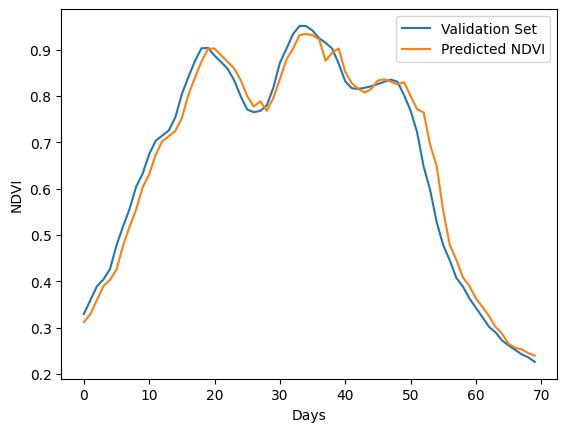

In [84]:
# load the dataset
values = list(y_new)
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, mse, y, yhat = walk_forward_validation(data, 70)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)
# plot expected vs preducted
plt.plot(y, label='Validation Set')
plt.plot(yhat, label='Predicted NDVI')
plt.ylabel("NDVI")
plt.xlabel("Days")
plt.legend()
plt.show()

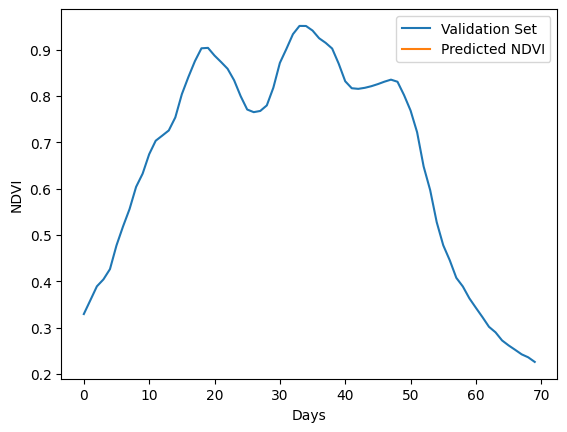

In [83]:
plt.plot(y, label='Validation Set')
plt.plot(yhat, label='Predicted NDVI')
plt.ylabel("NDVI")
plt.xlabel("Days")
plt.legend()


In [77]:
print('MAE: %.5f' % mae)
print('MSE: %.5f' % mse)

MAE: 0.02677
MSE: 0.00125


In [78]:
# load the dataset
values = list(y_new)
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=60)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', eval_metric="rmse", n_estimators=1000)
model.fit(trainX, trainy)

predictions = []

for i in range(150):
# construct an input for a new preduction
    row = values[-60:]
# make a one-step prediction
    yhat = model.predict(np.asarray([row]))
    values.append(yhat[0])
    predictions.append(yhat[0])
    #print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

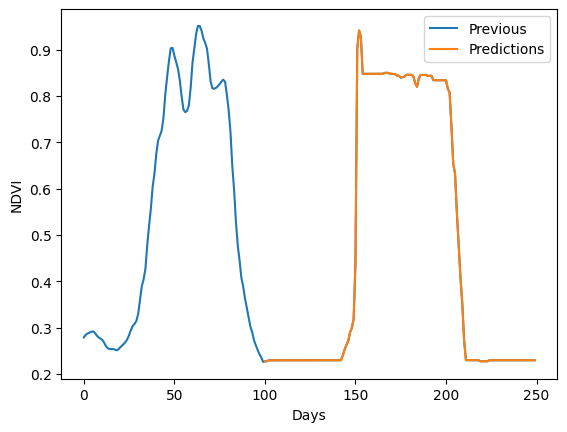

In [81]:
plt.plot([i for i in range(len(values))], values, label="Previous")
plt.plot([i for i in range(len(y_new), len(y_new)+len(predictions))], predictions, label="Predictions")
plt.ylabel("NDVI")
plt.xlabel("Days")
plt.legend()
plt.show()